<a href="https://colab.research.google.com/github/Sarojini96/Defect_Detection_MaskRcnn/blob/master/MaskrcnnTest2_crack_weld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Data Path
TRAIN_PATH = '/content/drive/My Drive/customImages/train/'
TEST_PATH = '/content/drive/My Drive/customImages/val/'
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
print("Please upload the config.py to your google colab")
from google.colab import files
src = list(files.upload().values())[0]
open('config.py','wb').write(src)
import config

Please upload the config.py to your google colab


Saving config.py to config.py


In [5]:
print("Please upload the utils.py to your google colab")
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
import utils

Please upload the utils.py to your google colab


Saving utils.py to utils.py


In [0]:
print("Please upload the model.py to your google colab")
from google.colab import files
src = list(files.upload().values())[0]
open('model.py','wb').write(src)
import model

In [0]:
print("Please upload the visualize.py to your google colab")
from google.colab import files
src = list(files.upload().values())[0]
open('visualize.py','wb').write(src)
import visualize


In [0]:
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from config import Config
import utils
import model as modellib
import visualize
from model import log
import skimage.draw

In [8]:
%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [105]:
class CustomConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "class"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # Background + defects

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 896
    IMAGE_MAX_DIM = 896
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 800
    
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 200
    # set validation steps 
    VALIDATION_STEPS = 50
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

# prepare config
config = CustomConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  896
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  896
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [896 896   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [0]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("class", 1, "weld defect")
        self.add_class("class", 2, "crack")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
            #circles = [r['shape_attributes'] for r in a['regions'].values()]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            
            self.add_image(
                "class",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)
              
            '''self.add_image(
                "object",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height, #come from right above
                circles=circles)'''
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a defect dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "class":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
        '''info = self.image_info[image_id] #jpg num
        mask = np.zeros([info["height"], info["width"], len(info["circles"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["circles"]):
            rr, cc = skimage.draw.circle(p["cx"], p["cy"], p["r"])
            print("p[cx] {}, p[cy] {}, p[r] {}".format(p["cx"], p["cy"], p["r"]))
            mask[rr, cc, i] = 1
            
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)'''
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "class":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [108]:
custom_DIR = os.path.join(ROOT_DIR, "/content/drive/My Drive/customImages/")
# Training dataset
dataset_train = CustomDataset()
dataset_train.load_custom(custom_DIR, "train")
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))
    # Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom(custom_DIR, "val")
dataset_val.prepare()
print('Test: %d' % len(dataset_val.image_ids))


Train: 89
Test: 23


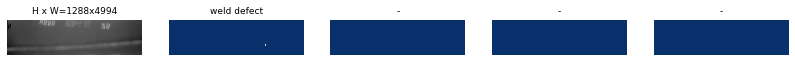

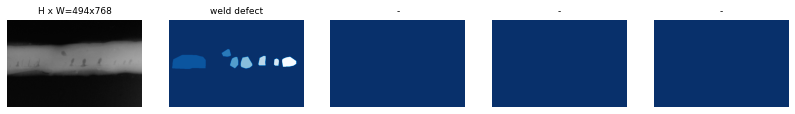

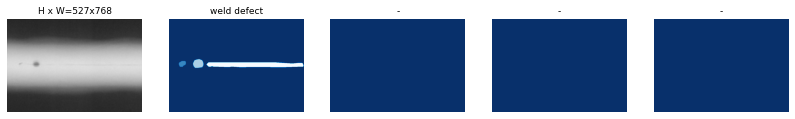

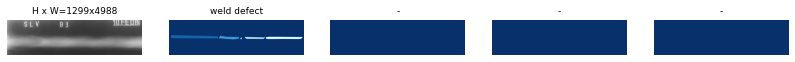

In [109]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [0]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [0]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

Training
Train in two stages:

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

In [114]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=2, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/class20200320T1049/mask_rcnn_class_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (T

/tensorflow-1.15.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 1/2
151/200 [=====================>........] - ETA: 1:04 - loss: 0.8786 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2679 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.2283 - mrcnn_mask_loss: 0.3416

ERROR:root:Error processing image {'id': 'W0001_0001.png', 'source': 'class', 'path': '/content/drive/My Drive/customImages/train/W0001_0001.png', 'width': 768, 'height': 366, 'polygons': [{'name': 'polygon', 'all_points_x': [294, 286, 286, 277, 272, 270, 268, 268, 269, 270, 272, 273, 285, 292, 294, 294], 'all_points_y': [154, 148, 148, 143, 144, 147, 155, 160, 162, 163, 164, 165, 172, 168, 166, 154]}, {'name': 'polygon', 'all_points_x': [282, 281, 280, 279, 276, 267, 264, 264, 271, 272, 273, 278, 286, 286, 288, 282], 'all_points_y': [182, 182, 181, 181, 181, 184, 190, 192, 203, 203, 203, 204, 203, 198, 188, 182]}, {'name': 'polygon', 'all_points_x': [266, 263, 249, 259, 262, 269, 270, 266], 'all_points_y': [204, 204, 215, 221, 221, 216, 211, 204]}, {'name': 'polygon', 'all_points_x': [322, 322, 321, 317, 313, 313, 312, 312, 315, 315, 318, 318, 327, 322], 'all_points_y': [220, 220, 217, 216, 220, 220, 220, 224, 229, 229, 232, 232, 226, 220]}, {'name': 'polygon', 'all_points_x': [321, 3

153/200 [=====================>........] - ETA: 1:01 - loss: 0.8754 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2666 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.2275 - mrcnn_mask_loss: 0.3405

ERROR:root:Error processing image {'id': 'W0001_0001.png', 'source': 'class', 'path': '/content/drive/My Drive/customImages/train/W0001_0001.png', 'width': 768, 'height': 366, 'polygons': [{'name': 'polygon', 'all_points_x': [294, 286, 286, 277, 272, 270, 268, 268, 269, 270, 272, 273, 285, 292, 294, 294], 'all_points_y': [154, 148, 148, 143, 144, 147, 155, 160, 162, 163, 164, 165, 172, 168, 166, 154]}, {'name': 'polygon', 'all_points_x': [282, 281, 280, 279, 276, 267, 264, 264, 271, 272, 273, 278, 286, 286, 288, 282], 'all_points_y': [182, 182, 181, 181, 181, 184, 190, 192, 203, 203, 203, 204, 203, 198, 188, 182]}, {'name': 'polygon', 'all_points_x': [266, 263, 249, 259, 262, 269, 270, 266], 'all_points_y': [204, 204, 215, 221, 221, 216, 211, 204]}, {'name': 'polygon', 'all_points_x': [322, 322, 321, 317, 313, 313, 312, 312, 315, 315, 318, 318, 327, 322], 'all_points_y': [220, 220, 217, 216, 220, 220, 220, 224, 229, 229, 232, 232, 226, 220]}, {'name': 'polygon', 'all_points_x': [321, 3

200/200 [==============================] - 295s 1s/step - loss: 0.8891 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2804 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.2283 - mrcnn_mask_loss: 0.3381 - val_loss: 2.4238 - val_rpn_class_loss: 0.1076 - val_rpn_bbox_loss: 1.5336 - val_mrcnn_class_loss: 0.0115 - val_mrcnn_bbox_loss: 0.3984 - val_mrcnn_mask_loss: 0.3726
Epoch 2/2
 96/200 [=============>................] - ETA: 1:33 - loss: 0.8717 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.2701 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.2386 - mrcnn_mask_loss: 0.3248

ERROR:root:Error processing image {'id': 'W0001_0001.png', 'source': 'class', 'path': '/content/drive/My Drive/customImages/train/W0001_0001.png', 'width': 768, 'height': 366, 'polygons': [{'name': 'polygon', 'all_points_x': [294, 286, 286, 277, 272, 270, 268, 268, 269, 270, 272, 273, 285, 292, 294, 294], 'all_points_y': [154, 148, 148, 143, 144, 147, 155, 160, 162, 163, 164, 165, 172, 168, 166, 154]}, {'name': 'polygon', 'all_points_x': [282, 281, 280, 279, 276, 267, 264, 264, 271, 272, 273, 278, 286, 286, 288, 282], 'all_points_y': [182, 182, 181, 181, 181, 184, 190, 192, 203, 203, 203, 204, 203, 198, 188, 182]}, {'name': 'polygon', 'all_points_x': [266, 263, 249, 259, 262, 269, 270, 266], 'all_points_y': [204, 204, 215, 221, 221, 216, 211, 204]}, {'name': 'polygon', 'all_points_x': [322, 322, 321, 317, 313, 313, 312, 312, 315, 315, 318, 318, 327, 322], 'all_points_y': [220, 220, 217, 216, 220, 220, 220, 224, 229, 229, 232, 232, 226, 220]}, {'name': 'polygon', 'all_points_x': [321, 3

102/200 [==============>...............] - ETA: 1:27 - loss: 0.8726 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.2737 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.2333 - mrcnn_mask_loss: 0.3277

ERROR:root:Error processing image {'id': 'W0001_0001.png', 'source': 'class', 'path': '/content/drive/My Drive/customImages/train/W0001_0001.png', 'width': 768, 'height': 366, 'polygons': [{'name': 'polygon', 'all_points_x': [294, 286, 286, 277, 272, 270, 268, 268, 269, 270, 272, 273, 285, 292, 294, 294], 'all_points_y': [154, 148, 148, 143, 144, 147, 155, 160, 162, 163, 164, 165, 172, 168, 166, 154]}, {'name': 'polygon', 'all_points_x': [282, 281, 280, 279, 276, 267, 264, 264, 271, 272, 273, 278, 286, 286, 288, 282], 'all_points_y': [182, 182, 181, 181, 181, 184, 190, 192, 203, 203, 203, 204, 203, 198, 188, 182]}, {'name': 'polygon', 'all_points_x': [266, 263, 249, 259, 262, 269, 270, 266], 'all_points_y': [204, 204, 215, 221, 221, 216, 211, 204]}, {'name': 'polygon', 'all_points_x': [322, 322, 321, 317, 313, 313, 312, 312, 315, 315, 318, 318, 327, 322], 'all_points_y': [220, 220, 217, 216, 220, 220, 220, 224, 229, 229, 232, 232, 226, 220]}, {'name': 'polygon', 'all_points_x': [321, 3

200/200 [==============================] - 193s 967ms/step - loss: 0.8997 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.2881 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.2424 - mrcnn_mask_loss: 0.3302 - val_loss: 2.3162 - val_rpn_class_loss: 0.1174 - val_rpn_bbox_loss: 1.3466 - val_mrcnn_class_loss: 0.0096 - val_mrcnn_bbox_loss: 0.4352 - val_mrcnn_mask_loss: 0.4074


In [115]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=3, 
            layers="all")


Starting at epoch 2. LR=0.0001

Checkpoint Path: /content/logs/class20200320T1049/mask_rcnn_class_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (

/tensorflow-1.15.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.0/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 3/3
 93/200 [============>.................] - ETA: 4:15 - loss: 0.8871 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.2510 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.2426 - mrcnn_mask_loss: 0.3489

ERROR:root:Error processing image {'id': 'W0001_0001.png', 'source': 'class', 'path': '/content/drive/My Drive/customImages/train/W0001_0001.png', 'width': 768, 'height': 366, 'polygons': [{'name': 'polygon', 'all_points_x': [294, 286, 286, 277, 272, 270, 268, 268, 269, 270, 272, 273, 285, 292, 294, 294], 'all_points_y': [154, 148, 148, 143, 144, 147, 155, 160, 162, 163, 164, 165, 172, 168, 166, 154]}, {'name': 'polygon', 'all_points_x': [282, 281, 280, 279, 276, 267, 264, 264, 271, 272, 273, 278, 286, 286, 288, 282], 'all_points_y': [182, 182, 181, 181, 181, 184, 190, 192, 203, 203, 203, 204, 203, 198, 188, 182]}, {'name': 'polygon', 'all_points_x': [266, 263, 249, 259, 262, 269, 270, 266], 'all_points_y': [204, 204, 215, 221, 221, 216, 211, 204]}, {'name': 'polygon', 'all_points_x': [322, 322, 321, 317, 313, 313, 312, 312, 315, 315, 318, 318, 327, 322], 'all_points_y': [220, 220, 217, 216, 220, 220, 220, 224, 229, 229, 232, 232, 226, 220]}, {'name': 'polygon', 'all_points_x': [321, 3

 97/200 [=============>................] - ETA: 3:59 - loss: 0.8849 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.2492 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.2420 - mrcnn_mask_loss: 0.3496

ERROR:root:Error processing image {'id': 'W0001_0001.png', 'source': 'class', 'path': '/content/drive/My Drive/customImages/train/W0001_0001.png', 'width': 768, 'height': 366, 'polygons': [{'name': 'polygon', 'all_points_x': [294, 286, 286, 277, 272, 270, 268, 268, 269, 270, 272, 273, 285, 292, 294, 294], 'all_points_y': [154, 148, 148, 143, 144, 147, 155, 160, 162, 163, 164, 165, 172, 168, 166, 154]}, {'name': 'polygon', 'all_points_x': [282, 281, 280, 279, 276, 267, 264, 264, 271, 272, 273, 278, 286, 286, 288, 282], 'all_points_y': [182, 182, 181, 181, 181, 184, 190, 192, 203, 203, 203, 204, 203, 198, 188, 182]}, {'name': 'polygon', 'all_points_x': [266, 263, 249, 259, 262, 269, 270, 266], 'all_points_y': [204, 204, 215, 221, 221, 216, 211, 204]}, {'name': 'polygon', 'all_points_x': [322, 322, 321, 317, 313, 313, 312, 312, 315, 315, 318, 318, 327, 322], 'all_points_y': [220, 220, 217, 216, 220, 220, 220, 224, 229, 229, 232, 232, 226, 220]}, {'name': 'polygon', 'all_points_x': [321, 3

200/200 [==============================] - 342s 2s/step - loss: 0.8251 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.2380 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.3218 - val_loss: 2.4541 - val_rpn_class_loss: 0.1182 - val_rpn_bbox_loss: 1.5262 - val_mrcnn_class_loss: 0.0099 - val_mrcnn_bbox_loss: 0.3974 - val_mrcnn_mask_loss: 0.4024


In [0]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_class_0001.h5")
model.keras_model.save_weights(model_path) 

original_image           shape: (896, 896, 3)         min:    0.00000  max:  235.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 4188.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  476.00000  max:  574.00000  int32
gt_mask                  shape: (896, 896, 1)         min:    0.00000  max:    1.00000  bool


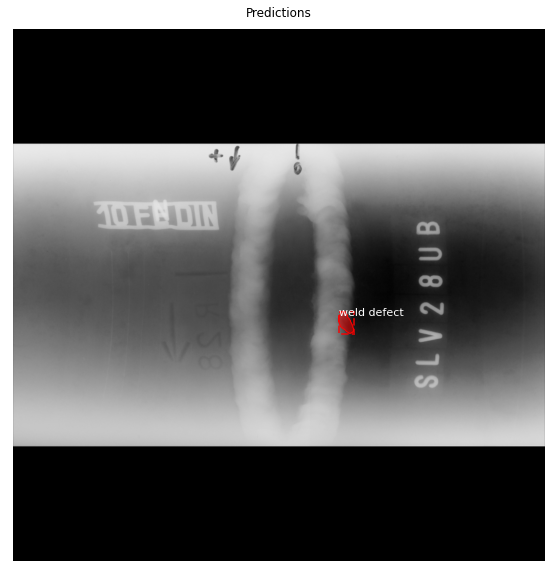

'visualize.display_instances(image, r[\'rois\'], r[\'masks\'], r[\'class_ids\'], \n                            dataset_train.class_names, r[\'scores\'],\n                            title="Predictions")'

In [147]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names,title="Predictions", figsize=(20, 10))
'''visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'],
                            title="Predictions")'''

Processing 1 images
image                    shape: (896, 896, 3)         min:    0.00000  max:  203.00000  uint8
molded_images            shape: (1, 896, 896, 3)      min: -123.70000  max:   99.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  896.00000  int64
anchors                  shape: (1, 200508, 4)        min:   -0.20226  max:    1.13075  float32


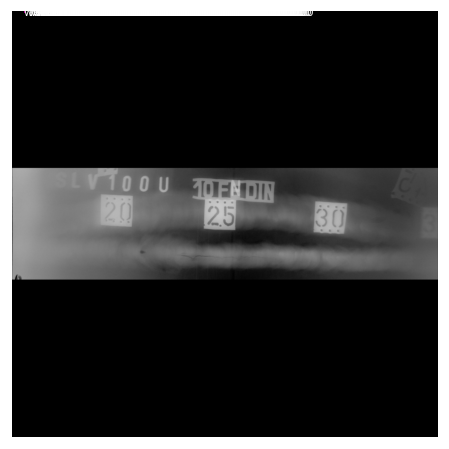

In [97]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())